# Assignment 10: Data Bias

## Hypothesis

I predict that Perspective API will more accurately mark the toxicity of longer comments (comments with 200+ characters) than shorter comments.

## Designing and Performing Tests

### Import necessary reacoures.

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier

In [89]:
!pip install scikit-learn==1.2.1

### Open the sample comments.

In [90]:
sample_df = pd.read_csv(r"C:\Users\ethan\Downloads\Sample_labaled_data_1.csv", encoding='utf8')
sample_df.head()

,Unnamed: 0,id,comment_text,toxic
0,5,0001ea8717f6de06,Thank you for understanding I think very highl...,no
1,7,000247e83dcc1211,Dear god this site is horrible,no
2,11,0002f87b16116a7f,Somebody will invariably try to add Religion ...,no
3,13,0003e1cccfd5a40a,It says it right there that it IS a type The...,no
4,14,00059ace3e3e9a53,Before adding a new product to the list mak...,no


In [91]:
comment_df = sample_df[["comment_text"]]
comment_df.head()

,comment_text
0,Thank you for understanding I think very highl...
1,Dear god this site is horrible
2,Somebody will invariably try to add Religion ...
3,It says it right there that it IS a type The...
4,Before adding a new product to the list mak...


### Select random comments into the testing sample.

In [92]:
toxic_actual = []
n = 0
X_test = comment_df
for count in range(0,len(X_test),4):
    if sample_df['toxic'][count] == 'yes':
        toxic_actual.append(1)
    else:
        toxic_actual.append(0)
    
    n+=1
    if n == 15:
        break

### Activate Perspective API.

In [93]:
pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

Note: you may need to restart the kernel to use updated packages.


In [94]:
from googleapiclient import discovery
import json
import os 

API_KEY = 'decoy_key'

In [95]:
client = discovery.build( "commentanalyzer",
  "v1alpha1",
  developerKey=API_KEY,
  discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
  static_discovery=False,)

### Find the toxicity score of the test sample comments using Perspective API.

In [96]:
n = 0
data = {'Comment': [],
        'Toxicity Score':[]}

for count in range(0,len(X_test),4):
    data['Comment'].append(X_test["comment_text"][count])
    
    analyze_request = {
      'comment': { 'text': X_test["comment_text"][count] },
      'requestedAttributes': {'TOXICITY': {}}
    }

    response = client.comments().analyze(body=analyze_request).execute()
    
    data['Toxicity Score'].append(response["attributeScores"]['TOXICITY']['summaryScore']['value'])
    
    n+=1
    if n == 15:
        break

df = pd.DataFrame(data)
df

,Comment,Toxicity Score
0,Thank you for understanding I think very highl...,0.016210
1,Before adding a new product to the list mak...,0.027089
2,Arabs are committing genocide in Iraq but no ...,0.718943
3,If Ollie or others think that one list of the ...,0.014011
4,balance This page has one sentence about th...,0.200097
5,September 20th Truce According to several n...,0.096118
6,I agree with Billfruge The author describes th...,0.017090
7,There are now four references including Brit...,0.199166
8,BrandonYusofToropov has requested mediation o...,0.050821
9,No he is an arrogant self serving immature idi...,0.877870


### Export the new data as a csv.

In [97]:
df.to_csv("sample_comments_test.csv")

### Use descriptpive statistics and graphs to help find the threshold for the model.

In [98]:
api_df = pd.read_csv("sample_comments_test.csv")
score = api_df["Toxicity Score"]
score.describe()

count    15.000000
mean      0.201608
std       0.270406
min       0.005592
25%       0.022089
50%       0.096118
75%       0.221461
max       0.877870
Name: Toxicity Score, dtype: float64

Text(0, 0.5, 'Frequency')

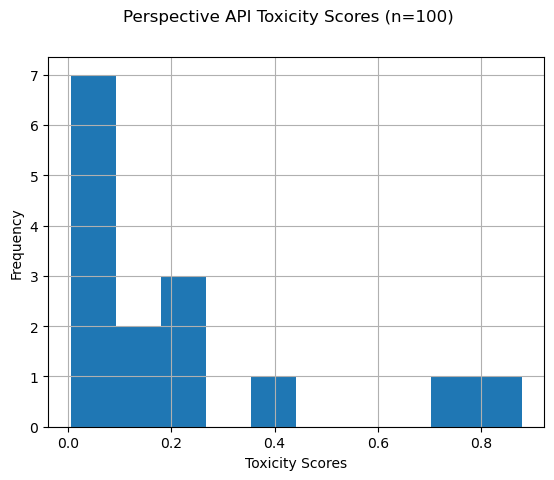

In [99]:
import pylab as pl
score.hist()
pl.suptitle("Perspective API Toxicity Scores (n=100)")
pl.xlabel("Toxicity Scores")
pl.ylabel("Frequency")

### Define and determine the number of long and short comments.

In [100]:
comment_column = api_df["Comment"]

shortComment_indices = []
longComment_indices = []

longComments = []
longScores = []
shortComments = []
shortScores = []
longActual = []
shortActual = []

for i in range(len(api_df["Comment"])):
    if len(comment_column[i]) >= 200:
        longComment_indices.append(i)
        longComments.append(api_df["Comment"][i])
        longScores.append(api_df["Toxicity Score"][i])
        longActual.append(toxic_actual[i])
    else:
        shortComment_indices.append(i)
        shortComments.append(api_df["Comment"][i])
        shortScores.append(api_df["Toxicity Score"][i])
        shortActual.append(toxic_actual[i])
        
testLong_df = pd.DataFrame({'Long Comment':longComments,
                        'Predicted Score (from API)':longScores,
                        'Actual Score':longActual
})

testShort_df = pd.DataFrame({'Short Comment': shortComments,
                        'Predicted Score (from API)':shortScores,
                        'Actual Score':shortActual
})

print("Number of short comments:",len(shortComment_indices))
print("Number of long comments:",len(longComment_indices))

Number of short comments: 5
Number of long comments: 10


In [101]:
testShort_df

,Short Comment,Predicted Score (from API),Actual Score
0,Thank you for understanding I think very highl...,0.016210,0
1,Arabs are committing genocide in Iraq but no ...,0.718943,1
2,September 20th Truce According to several n...,0.096118,0
3,No he is an arrogant self serving immature idi...,0.877870,1
4,black mamba Itis ponious snake of the word ...,0.426917,0


In [102]:
testLong_df

,Long Comment,Predicted Score (from API),Actual Score
0,Before adding a new product to the list mak...,0.027089,0
1,If Ollie or others think that one list of the ...,0.014011,0
2,balance This page has one sentence about th...,0.200097,0
3,I agree with Billfruge The author describes th...,0.017090,0
4,There are now four references including Brit...,0.199166,0
5,BrandonYusofToropov has requested mediation o...,0.050821,0
6,Main towns that are not so main I know th...,0.103928,0
7,Cloud feedback Why is cloud feedback only...,0.027442,0
8,Redirects トレイン・トレイン トレイン トレイン トレイントレイン トレイントレ...,0.005592,0
9,Firstly still making undiffable edits and re...,0.242826,0


### Find the overall accury of Perspective API with a threshold toxicity score of 0.25.

In [103]:
toxic_map_predicted = []
for index in range(len(api_df["Toxicity Score"])):
    if api_df["Toxicity Score"][index] <=0.25:
        toxic_map_predicted.append(0)
    else:
        toxic_map_predicted.append(1)

accuracy = accuracy_score(toxic_map_predicted,toxic_actual)
print (f"Accuracy of the classifier = {accuracy}")

toxic_actual_longComment = [toxic_actual[i] for i in longComment_indices]
toxic_predicted_longComment = [toxic_map_predicted[i] for i in longComment_indices]

toxic_actual_shortComment = [toxic_actual[i] for i in shortComment_indices]
toxic_predicted_shortComment = [toxic_map_predicted[i] for i in shortComment_indices]

Accuracy of the classifier = 0.9333333333333333


### Find the accuracy of Perspective API in relation to comment length. 

In [104]:
def class_wise_acc(toxic_actual, toxic_predicted):
    total_p = .01
    total_n = .01
    TP=0
    TN=0
    
    for i in range(len(toxic_predicted)):
        if toxic_actual[i]==1:
            total_p = total_p+1
            if toxic_actual[i]==toxic_predicted[i]:
               TP=TP+1
        if toxic_actual[i]==0:
            total_n=total_n+1
            if toxic_actual[i]==toxic_predicted[i]:
               TN=TN+1
    return(TP/total_p, TN/total_n)

class_1_acc_longComment, class_0_acc_longComment = class_wise_acc(toxic_actual_longComment, toxic_predicted_longComment)
class_1_acc_shortComment, class_0_acc_shortComment = class_wise_acc(toxic_actual_shortComment, toxic_predicted_shortComment)

print (f"Class 1 (i.e., predicted toxicity score > 0.25) accuracy for Long Comments = {class_1_acc_longComment}")
print (f"Class 0 (i.e., predicted toxicity score <= 0.25) accuracy for Long Comments = {class_0_acc_longComment}")
print (f"Class 1 (i.e., predicted toxicity score > 0.25) accuracy for Short Comments = {class_1_acc_shortComment}")
print (f"Class 0 (i.e., predicted toxicity score <= 0.25) accuracy for Short Comments = {class_0_acc_shortComment}")

Class 1 (i.e., predicted toxicity score > 0.25) accuracy for Long Comments = 0.0
Class 0 (i.e., predicted toxicity score <= 0.25) accuracy for Long Comments = 0.999000999000999
Class 1 (i.e., predicted toxicity score > 0.25) accuracy for Short Comments = 0.9950248756218907
Class 0 (i.e., predicted toxicity score <= 0.25) accuracy for Short Comments = 0.6644518272425249


### Results

My hypothesis was definitely not correct according to the results of my testing. Perspective API showed very high accuracy for long, non-toxic comments and short, toxic comments. On the contrary, it had moderate accuracy for short, non-toxic comments and zero percent accuracy for long, toxic comments.

I think a large reason these results is actually do to how small the sample size that I tested was. I actually choose to include only 15 comments in my testing sample because I was having a lot of techinical difficulties when using a larger sample size, but in hind sight I think hurt the accuracy of my study.

Assuming my results are accurate regardless of my small sample size, I have a few guesses as to why the accuracy in relation to comment length might be like this.

For the high accuracy for long, non-toxic comments, I think that having a lot of words to provide context for words or phrases that might be flagged as toxic helped the API avoid flagging entire comments as toxic for including one toxic word.

I think the reason for the high accuracy in identifying short, toxic comments is because the API identifies single toxic words or phrases that make up a majority of the comment, without other clutter or conext.

I think the moderate accuracy for short, non-toxic comments is due to a lack of other words for context, or simply as filler, to mitigate the impact of one toxic word or phrase on the toxicity rating.

Finally, I am pretty confident that the 0% accuracy for long, toxic comments is due to the small sample size. I curious as to how the accuracy of the API would change for these types of comments with a larger sample size.